# Medidas de taxa de juros real neutra no Brasil

A taxa de juros real neutra da economia é um elemento crucial na formulação da política monetária. Ela pode ser definida como a taxa que, a médio prazo, mantém a inflação na meta e o crescimento do produto igual ao crescimento potencial (Blinder, 1998). Quando a taxa de juros real efetiva fica acima da taxa neutra, a política monetária é considerada contracionista; quando está abaixo, é considerada expansionista.

Vou me beasear no [Boxe Medidas de taxa de juros real neutra no Brasil do Relatório de Inflação de 2023](https://www.bcb.gov.br/content/ri/relatorioinflacao/202306/ri202306b6p.pdf), bem como também em literaturas subjacentes para construir diferentes tipos de medidas para o juro neutro no Brasil.

As estimativas da taxa de juros real neutra são elaboradas com base na aplicação de filtros estatísticos, apoiados por teorias econômicas em diferentes níveis. Durante esse processo, surgem desafios técnicos relacionados à coleta de dados e uso de ferramentas estatísticas, mas nossa abordagem sempre segue uma lógica consistente.


In [51]:
!pip install ipeadatapy
import ipeadatapy as ip

# 1. Carrega as bibliotecas

In [1]:
import numpy as np
import datetime
from datetime import datetime
from bcb import Expectativas
from bcb import sgs
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functools import reduce

# 1.1 Taxas de juros reais ex-ante da pesquisa Focus

Intuitivamente, taxas de juros correntes inferiores às taxas esperadas em prazos mais longos estimulam a demanda e a oferta de crédito, tanto para
consumo, quanto para investimento

Isso por que taxas de juros de prazo mais longo geralmente servem como uma boa aproximação inicial para as taxas de juros neutras, embora seja possível aprimorar essa aproximação, eliminando eventuais efeitos cíclicos que ainda possam influenciar as taxas mais longas.

Nesse cenário, recorri à pesquisa Focus tanto para obter as taxas de médio prazo por meio de cálculos diretos, quanto para auxiliar na identificação dos prêmios de risco associados às taxas de mercado em diversos horizontes, incluindo o horizonte de um ano.

A ideia será obter a mediana da distribuilção das taxas nominais previstas pelos entrevistados para horizontes de curto prazo (um ano) e médio prazo (quatro anos).

A primeira abordagem é baseada em taxas de juros reais ex-ante extraída da pesquisa Focus, ou seja, as medianas das taxas de juros nominais deflacionadas pelas expectativas medianas de inflação em cada horizonte, obtendo as taxas reais ex-ante.

Usando o horizonte 4 anos, pode-se argumentar que se refere a uma taxas mais longa, livre de prêmios de risco, assim, essa estimativa da taxa de juros real neutra é a própria taxa ex-ante de quatro anos da pesquisa Focus, ou seja, $R_{t}^{n|focus4} = R_{t}^{focus4}$

Ao adotar um horizonte de um ano, enfrenta-se a questão das taxas de curto prazo, que incluem prêmios de risco. Para lidar com isso, aplicamos o filtro HP para remover esse componente.

Nesse contexto, o principal desafio reside na coleta e no tratamento dos dados da Pesquisa, visando a obtenção das expectativas da Taxa Selic e do IPCA. Isso permite, posteriormente, utilizar a equação de Fisher para calcular a Taxa de Juros Real.





### Funções auxiliares

Começamos criando funções auxiliares para facilitar o tratamento de dados e a obtenção da taxas de juros real via equação de fisher.

In [2]:
# Cria uma função para a equação de fisher
def fisher(juros, inflacao):
    """
    Calcula a taxa de juros real neutra usando a equação de Fisher.

    Args:
        juros (float): A taxa de juros nominal em porcentagem (%).
        inflacao (float): A taxa de inflação em porcentagem (%).

    Returns:
        float: A taxa de juros real em porcentagem (%).

    Raises:
        TypeError: Se os argumentos `juros` e `inflacao` não forem do tipo `float`.

    Exemplo:
        >>> fisher(10, 3)
        6.796116504854364
    """
    juros = ((((1 + (juros / 100)) / (1 + inflacao / 100))) -1) * 100
    return juros

# Cria função para calcular a data de referência a partir da data de observação
def reference_date(date: str, n):
    """
    Calcula a data de referência adicionando 3 anos a uma data de observação.

    Args:
        date (str): Uma string que representa uma data no formato 'YYYY-MM-DD'.

    Returns:
        List[str]: Uma lista de strings com a data de referência no formato 'YYYY'.

    Raises:
        TypeError: Se o argumento `date` não for uma string.

    Examples:
        >>> reference_date('2022-01-01', n = 3)
        ['2025']
    """
    years = pd.DatetimeIndex(date).year.values + n # Calcula n anos a frente
    years = years.tolist()
    years = [str(i) for i in years]
    return years

# Cores para gráficos
colors = {'blue': '#282f6b',
          'red'   : "#b22200",
          'green': '#224f20',
          'yellow': '#eace3f',
          'gray': '#666666',
          'orange' : '#b35c1e',
          'purple' : "#5f487c"
          }

### Importa e trata os dados

Precisam-se importar as medianas das projeções do IPCA e da SELIC anuais. Dessa forma, podemos separar cada horizonte e realizar o deflacionamento para obter as taxas de juros reais.

#### Expectativa do IPCA

In [54]:
# instância a classe de Expectativas
em = Expectativas()

# Conecta com a API das Expectativas de Mercado Anuais
exp_anual = em.get_endpoint('ExpectativasMercadoAnuais')

# Importa as expectativas do IPCA anuais e realiza os filtros
ipca_e_raw = (
  exp_anual.query()
  .filter(exp_anual.Indicador == "IPCA")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

In [55]:
ipca_e_raw

,Data,DataReferencia,Mediana
0,2000-01-03,2000,7.0000
1,2000-01-04,2000,7.0000
2,2000-01-05,2000,7.0000
3,2000-01-06,2000,7.0000
4,2000-01-07,2000,7.0000
...,...,...,...
29557,2024-05-10,2024,3.7611
29558,2024-05-10,2025,3.6597
29559,2024-05-10,2026,3.5000
29560,2024-05-10,2027,3.5000


In [5]:
# Realiza o filtro para a data de referência 1 anos a frente das obs.
ipca_e_t1 = ipca_e_raw[(
            ipca_e_raw
            .DataReferencia == reference_date(ipca_e_raw['Data'], n = 1)
            )]

# Realiza o filtro para a data de referência 4 anos a frente das obs.
ipca_e_t4 = ipca_e_raw[(
            ipca_e_raw
            .DataReferencia == reference_date(ipca_e_raw['Data'], n = 4)
            )]

In [6]:
ipca_e_t1

,Data,DataReferencia,Mediana
9,2000-01-13,2001,4.0000
11,2000-01-14,2001,4.0000
13,2000-01-17,2001,4.0000
15,2000-01-18,2001,4.0000
17,2000-01-19,2001,4.0000
...,...,...,...
29538,2024-05-06,2025,3.6400
29543,2024-05-07,2025,3.6492
29548,2024-05-08,2025,3.6492
29553,2024-05-09,2025,3.6496


In [7]:
ipca_e_t4

,Data,DataReferencia,Mediana
1326,2001-11-06,2005,3.0
1331,2001-11-07,2005,3.0
1336,2001-11-08,2005,3.5
1341,2001-11-09,2005,3.5
1346,2001-11-12,2005,3.5
...,...,...,...
29541,2024-05-06,2028,3.5
29546,2024-05-07,2028,3.5
29551,2024-05-08,2028,3.5
29556,2024-05-09,2028,3.5


In [8]:
# Renomeia as colunas e mensaliza
ipca_e_t1 = (
              ipca_e_t1
              .rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'ipca_e_t1'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'ipca_e_t1']]
              .groupby(by = 'date')
              .agg(ipca_e_t1 = ('ipca_e_t1', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )

# Renomeia as colunas e mensaliza
ipca_e_t4 = (
              ipca_e_t4.rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'ipca_e_t4'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'ipca_e_t4']]
              .groupby(by = 'date')
              .agg(ipca_e_t4 = ('ipca_e_t4', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )

#### Expectativa da SELIC

In [9]:
# Importa as expectativas da Selic anuais e realiza os filtros
selic_e_raw = (
   exp_anual.query()
  .filter(exp_anual.Indicador == "Selic")
  .filter(exp_anual.baseCalculo == 0)
  .select(exp_anual.Data, exp_anual.Mediana, exp_anual.DataReferencia)
  .collect()
  )

# Realiza o filtro para a data de referência 1 ano a frente das obs.
selic_e_t1 = selic_e_raw[(
                        selic_e_raw
                        .DataReferencia == reference_date(selic_e_raw['Data'], n = 1)
                        )]

# Realiza o filtro para a data de referência 4 anos a frente das obs.
selic_e_t4 = selic_e_raw[(
                        selic_e_raw
                        .DataReferencia == reference_date(selic_e_raw['Data'], n = 4)
                        )]

In [10]:
# Renomeia as colunas
selic_e_t1 = (
              selic_e_t1.rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'selic_e_t1'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'selic_e_t1']]
              .groupby(by = 'date')
              .agg(selic_e_t1 = ('selic_e_t1', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )

# Renomeia as colunas
selic_e_t4 = (
              selic_e_t4.rename(columns =
                                        {'Data' : 'date',
                                        'Mediana' : 'selic_e_t4'})
              .drop(['DataReferencia'], axis = 1)
              .assign(date = lambda x: pd.PeriodIndex(x['date'], freq = 'M'))
              .loc[:, ['date', 'selic_e_t4']]
              .groupby(by = 'date')
              .agg(selic_e_t4 = ('selic_e_t4', 'mean'))
              .reset_index()
              .assign(date = lambda x : x.date.dt.to_timestamp())
            )

### Proxy Neutro T4

Temos então a medida $R_{t}^{n|focus4} = R_{t}^{focus4}$ abaixo.

In [11]:
# Junta os dados em um data frame
proxy_neutro_t4 = (
                pd.merge(left = ipca_e_t4,
                        right = selic_e_t4,
                        how = 'inner',
                        on = 'date')
                .assign(neutro_t4 = lambda x : fisher(x.selic_e_t4, x.ipca_e_t4))
                )

# Trimestraliza o juro neutro
proxy_neutro_t4 = (
    proxy_neutro_t4
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['date'], freq = 'Q'))
    .loc[:, ['date_quarter', 'neutro_t4']]
    .groupby(by = 'date_quarter')
    .agg(neutro = ('neutro_t4', 'mean'))
    .reset_index()
)

proxy_neutro_t4

,date_quarter,neutro
0,2001Q4,8.688995
1,2002Q1,7.621214
2,2002Q2,8.189138
3,2002Q3,8.287175
4,2002Q4,8.151794
...,...,...
86,2023Q2,4.833656
87,2023Q3,4.998616
88,2023Q4,4.830918
89,2024Q1,4.791209


### Proxy Neutro T1 (Filtro HP)

Temos então a segunda estimativa $R_{t}^{n|focus1} = R_{t}^{focus1}$ abaixo.

In [12]:
# Junta os dados em um data frame
proxy_neutro_t1 = (
                pd.merge(left = ipca_e_t1,
                        right = selic_e_t1,
                        how = 'inner',
                        on = 'date')
                .assign(neutro_t1 = lambda x : fisher(x.selic_e_t1, x.ipca_e_t1))
                )

# Trimestraliza o juro neutro
proxy_neutro_t1 = (
    proxy_neutro_t1
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['date'], freq = 'Q'))
    .loc[:, ['date_quarter', 'neutro_t1']]
    .groupby(by = 'date_quarter')
    .agg(proxy_neutro_t1 = ('neutro_t1', 'mean'))
)

proxy_neutro_t1

,proxy_neutro_t1
date_quarter,
2000Q1,10.476964
2000Q2,10.079362
2000Q3,9.234992
2000Q4,9.002161
2001Q1,8.458483
...,...
2023Q2,5.562601
2023Q3,5.084578
2023Q4,5.065699


In [13]:
# Calcula o filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x = proxy_neutro_t1['proxy_neutro_t1'], lamb = 1600)

# Salva a tendência calculada
proxy_neutro_hp = pd.DataFrame(filtro_hp[1]).reset_index() # posição 1 é a tendência (0=ciclo);

In [14]:
proxy_neutro_hp

,date_quarter,proxy_neutro_t1_trend
0,2000Q1,10.021764
1,2000Q2,9.952631
2,2000Q3,9.883783
3,2000Q4,9.815583
4,2001Q1,9.747989
...,...,...
93,2023Q2,4.703240
94,2023Q3,4.896156
95,2023Q4,5.087711
96,2024Q1,5.278462


### Visualiza as duas estimativas



In [15]:
# Junta os dados e transforma de wide para long
proxy1 = (
          pd.merge(proxy_neutro_t4, proxy_neutro_hp, on = 'date_quarter')
          .assign(date_quarter = lambda x: x.date_quarter.dt.to_timestamp())
          .rename(columns = {'proxy_neutro_t1_trend' : 'Selic real esperada em 1 ano, filtro HP (Focus)',
                             'neutro' : 'Selic real esperada em 4 anos (Focus)'})
          .melt(id_vars = ['date_quarter'], var_name = 'proxy', value_name = 'values')
          )

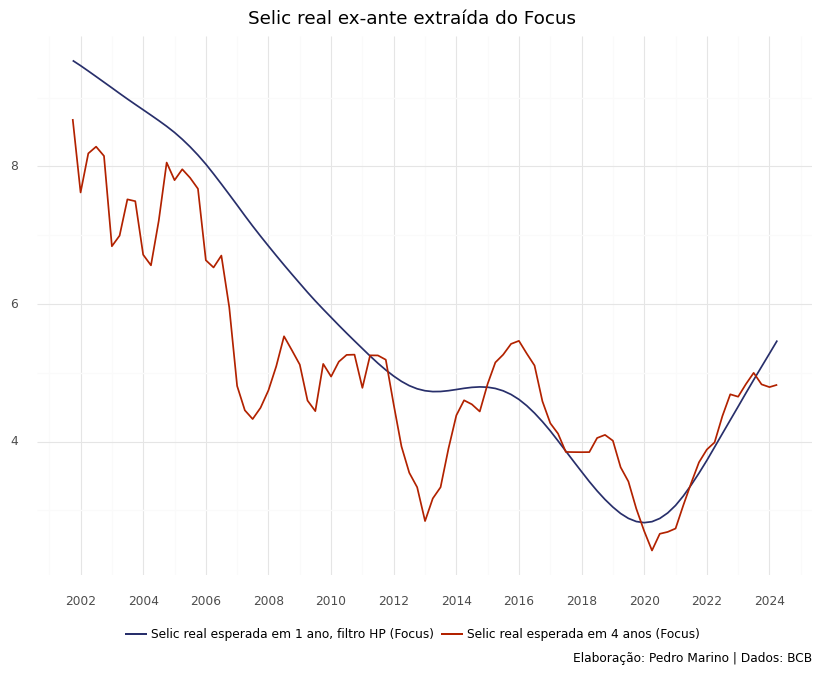

<ggplot: (164276077050)>

In [16]:
(
 ggplot(proxy1, aes(x = 'date_quarter', y = 'values', color = 'proxy')) +
 geom_line(size = 0.7) +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
 labs(title = "Selic real ex-ante extraída do Focus",
      color="",
      x="",
      y="",
      caption = "Elaboração: Pedro Marino | Dados: BCB")+
 theme_minimal() +
 theme(legend_position = "bottom", figure_size = (10, 7))
)

# 1.2. Taxas Neutras de alta e baixa frequência

Conforme o Boxe "Medidas de taxa de juros real neutra no Brasil" as estimativas seguintes são baseadas em Roberts (2018).

A ideia básica do autor é a de extrair de taxas longas relevantes para o comportamento de consumo e investimento uma "taxa neutra de alta frequência", ou seja, aquela que mantém o hiato do produto em zero em cada ponto do tempo.

Sendo assim, a partir da "taxa neutra de alta frequência", o autor propõe suavizá-la, de forma a expurgar erros de medida e componentes cíclicos, e assim obter a "taxa neutra de baixa frequência".

Para obter a taxa neutra “de alta frequência” $R_{t}^{n,af}$ como a solução da seguinte equação, que representa uma curva IS estilizada e assim captura o efeito dos juros sobre o hiato da economia:

$$ hiato_t = \eta \ hiato_{n-1} - \sigma(R_{t}{Focus4} - R_{t}^{n,af})$$

Rearranjamos a equação e obtemos:

$$ R_{t}^{n,af} = R_{t} + \frac{(hiato_t - \eta \ hiato_{n-1})}{\sigma} $$

O hiato é uma medida do hiato do produto que pode ser obtida de diferentes formas. Aqui, usamos o filtro HP e Hamilton para a série dessazonalida do PIB, bem como usamos o Hiato do Produto estimado pelo próprio BCB.

O parâmetro é $\eta$ uma medida de persistência do hiato, que calibramos em 0,84 com base na persistência média dos hiatos utilizados no exercício do Banco Central. O parâmetro $\sigma$ mede o efeito sobre a atividade do nível de aperto da política monetária, medido em termos de taxas de médio prazo, sendo calibrado em 0,75 como sugerido em Roberts (2018).

Portanto, precisamos obter as estimativas do Hiato do Produto. Abaixo, importamos a série do Hiato do BCB. Também importamos a série do PIB e utilizamos os devidos filtro para a obtenção do Hiato.

## Hiato do Produto

In [17]:
# Coleta e tratamento do Hiato do Produto do BC
hiato = (
    pd.read_excel(
    "https://www.bcb.gov.br/content/ri/relatorioinflacao/202403/ri202403anp.xlsx",
    sheet_name = "Graf 2.2.4",
    skiprows = 8
    )
    .assign(date_quarter = lambda x: pd.PeriodIndex(x['Trimestre'], freq = 'Q'),
            hiato_bcb = lambda x: x.Hiato.astype(float))
    .loc[:, ['date_quarter', 'hiato_bcb']]
    .set_index('date_quarter')
  )

In [18]:
hiato

,hiato_bcb
date_quarter,
NaT,NaN
2003Q4,-0.83
2004Q1,-0.40
2004Q2,-0.03
2004Q3,0.35
...,...
2023Q1,-0.61
2023Q2,-0.64
2023Q3,-0.66


In [19]:
# Coleta dos dados do PIB
pib = (
        sgs.get({'pib' : 22109}) # coleta
        .assign(date_quarter = lambda x: pd.PeriodIndex(x.index , freq = 'Q')) # transforma a coluna de data
        .set_index('date_quarter') # adiciona a coluna de data no índice
      )

In [20]:
pib

,pib
date_quarter,
1996Q1,99.42
1996Q2,100.65
1996Q3,104.16
1996Q4,103.38
1997Q1,104.41
...,...
2022Q4,179.97
2023Q1,182.35
2023Q2,183.88


In [21]:
# Calcula o filtro HP
filtro_hp = sm.tsa.filters.hpfilter(x = pib['pib'], lamb = 1600)

# Salva a tendência calculada
potencial_hp = filtro_hp[1] # posição 1 é a tendência (0=ciclo);

hiato['hiato_hp'] = (pib["pib"] / potencial_hp - 1) * 100

In [22]:
# Regressão linear aplicando a especificação de Hamilton
reg3 = smf.ols(
    formula = "pib ~ pib.shift(8) + pib.shift(9) + pib.shift(10) + pib.shift(11)",  # especificação do modelo no formato de fórmula
    data = pib  # fonte dos dados
    ).fit() # estima o modelo

# Salva a tendência estimada
potencial_h = reg3.predict() # extrai os valores estimados

# Adiciona 11 NaNs no início da série para corresponder ao tamanho da série do PIB
potencial_h = np.append([np.nan]*11, potencial_h)

# calcula o hiato
hiato['hiato_hamilton'] = (pib["pib"] / potencial_h - 1) * 100

In [23]:
hiato

,hiato_bcb,hiato_hp,hiato_hamilton
date_quarter,,,
NaT,NaN,NaN,NaN
2003Q4,-0.83,-1.870282,-1.400129
2004Q1,-0.40,-1.300807,-2.112677
2004Q2,-0.03,0.429752,0.513405
2004Q3,0.35,0.669669,0.072779
...,...,...,...
2023Q1,-0.61,1.425203,2.495268
2023Q2,-0.64,1.672962,4.135076
2023Q3,-0.66,1.108455,4.254518


## Taxa real de alta frequência

Calculamos abaixo a taxa real de alta frequência

In [24]:
# Junta o Hiato com a proxy R_t4 (taxa de alta frequência)
taxa_freq = proxy_neutro_t4.set_index('date_quarter').join(hiato, on = 'date_quarter').dropna()

In [25]:
# Produz a taxa real de baixa frequência
taxa_freq['r_n_bcb'] = (taxa_freq.neutro + (taxa_freq.hiato_bcb - 0.84 * (taxa_freq.hiato_bcb.shift(1))) / 0.75)
taxa_freq['r_n_hp'] = (taxa_freq.neutro + (taxa_freq.hiato_hp - 0.84 * (taxa_freq.hiato_hp.shift(1))) / 0.75)
taxa_freq['r_n_hamilton'] = (taxa_freq.neutro + (taxa_freq.hiato_hamilton - 0.84 * (taxa_freq.hiato_hamilton.shift(1))) / 0.75)

In [26]:
taxa_freq

,neutro,hiato_bcb,hiato_hp,hiato_hamilton,r_n_bcb,r_n_hp,r_n_hamilton
date_quarter,,,,,,,
2003Q4,7.494154,-0.83,-1.870282,-1.400129,NaN,NaN,NaN
2004Q1,6.716224,-0.40,-1.300807,-2.112677,7.112491,7.076531,5.467466
2004Q2,6.561729,-0.03,0.429752,0.513405,6.969729,8.591635,9.612467
2004Q3,7.211693,0.35,0.669669,0.072779,7.711960,7.623263,6.733718
2004Q4,8.056173,0.63,0.521221,0.412920,8.504173,8.001105,8.525221
...,...,...,...,...,...,...,...
2022Q4,4.686400,-0.58,0.695463,4.516317,4.551467,4.376778,5.026481
2023Q1,4.651697,-0.61,1.425203,2.495268,4.487964,5.773050,2.920447
2023Q2,4.833656,-0.64,1.672962,4.135076,4.663523,5.468044,7.552390


### Visualiza os dados

In [27]:
# Realiza tratamento para o plot
proxy2_af = (
    taxa_freq
    .reset_index()
    .drop(['hiato_bcb', 'hiato_hp', 'hiato_hamilton'], axis = 1)
    .assign(date_quarter = lambda x: x.date_quarter.dt.to_timestamp())
    .rename(columns = {'r_n_bcb' : 'Hiato BCB',
                       'r_n_hp' : 'Hiato Filtro HP',
                       'r_n_hamilton' : 'Hiato Filtro de Hamilton',
                       'neutro' : 'Selic real esperada em 4 anos (Focus)'})
     .melt(id_vars = ['date_quarter'], var_name = 'proxy', value_name = 'values')
  )
proxy2_af

,date_quarter,proxy,values
0,2003-10-01,Selic real esperada em 4 anos (Focus),7.494154
1,2004-01-01,Selic real esperada em 4 anos (Focus),6.716224
2,2004-04-01,Selic real esperada em 4 anos (Focus),6.561729
3,2004-07-01,Selic real esperada em 4 anos (Focus),7.211693
4,2004-10-01,Selic real esperada em 4 anos (Focus),8.056173
...,...,...,...
319,2022-10-01,Hiato Filtro de Hamilton,5.026481
320,2023-01-01,Hiato Filtro de Hamilton,2.920447
321,2023-04-01,Hiato Filtro de Hamilton,7.552390
322,2023-07-01,Hiato Filtro de Hamilton,6.040022


c:\Users\pedro\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


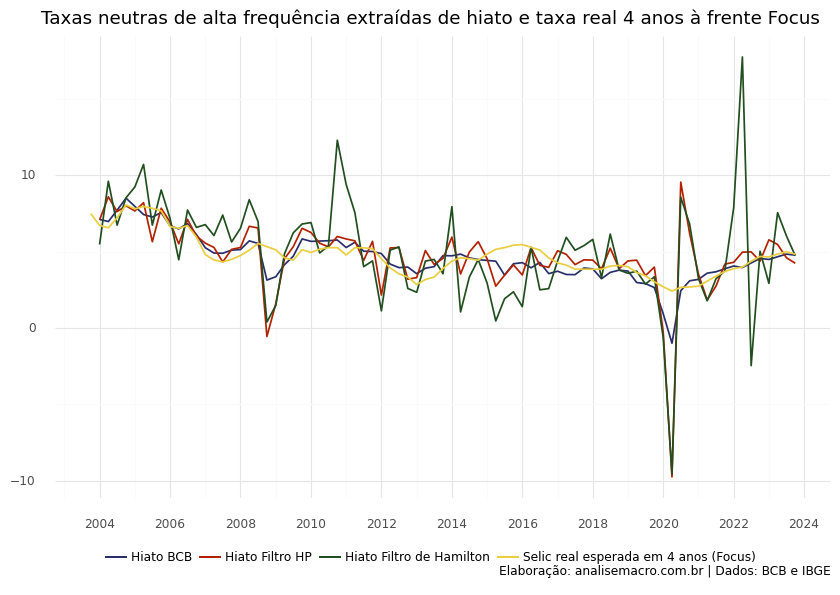

<ggplot: (164275624442)>

In [28]:
# Cria o gráfico
(
 ggplot(proxy2_af, aes(x = 'date_quarter', y = 'values', color = 'proxy')) +
 geom_line(size = 0.7) +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
 labs(title = "Taxas neutras de alta frequência extraídas de hiato e taxa real 4 anos à frente Focus",
      color="",
      x="",
      y="",
      caption = "Elaboração: Pedro Marino | Dados: BCB e IBGE")+
 theme_minimal() +
 theme(legend_position = "bottom",
       figure_size = (10, 6))
)

## Taxa real de baixa frequência

De forma remover os componentes cíclicos e suavizar a série, obtemos a taxa real de baixa frequência aplicando um Filtro HP sobre os dados da taxa de juros de alta frequência. Sendo assim, temos:

$$ R_{t}^{n,bf} = filtro(R_{t}^{n, af}) $$

In [29]:
# retire os dados faltantes
taxa_freq.dropna(inplace = True)

In [30]:
taxa_freq

,neutro,hiato_bcb,hiato_hp,hiato_hamilton,r_n_bcb,r_n_hp,r_n_hamilton
date_quarter,,,,,,,
2004Q1,6.716224,-0.40,-1.300807,-2.112677,7.112491,7.076531,5.467466
2004Q2,6.561729,-0.03,0.429752,0.513405,6.969729,8.591635,9.612467
2004Q3,7.211693,0.35,0.669669,0.072779,7.711960,7.623263,6.733718
2004Q4,8.056173,0.63,0.521221,0.412920,8.504173,8.001105,8.525221
2005Q1,7.800186,0.65,0.336052,1.424753,7.961253,7.664488,9.237386
...,...,...,...,...,...,...,...
2022Q4,4.686400,-0.58,0.695463,4.516317,4.551467,4.376778,5.026481
2023Q1,4.651697,-0.61,1.425203,2.495268,4.487964,5.773050,2.920447
2023Q2,4.833656,-0.64,1.672962,4.135076,4.663523,5.468044,7.552390


In [31]:
# Calcula o filtro HP para cada medida da taxa real de alta frequência
taxa_freq['r_n_bcb_bf'] =  sm.tsa.filters.hpfilter(x = taxa_freq['r_n_bcb'], lamb = 1600)[1] # Hiato BCB
taxa_freq['r_n_hp_bf'] =  sm.tsa.filters.hpfilter(x = taxa_freq['r_n_hp'], lamb = 1600)[1] # Hiato HP
taxa_freq['r_n_hamilton_bf'] =  sm.tsa.filters.hpfilter(x = taxa_freq['r_n_hamilton'], lamb = 1600)[1] # Hiato Hamilton
taxa_freq['neutro_bf'] =  sm.tsa.filters.hpfilter(x = taxa_freq['neutro'], lamb = 1600)[1] # Selic t4

taxa_freq

,neutro,hiato_bcb,hiato_hp,hiato_hamilton,r_n_bcb,r_n_hp,r_n_hamilton,r_n_bcb_bf,r_n_hp_bf,r_n_hamilton_bf,neutro_bf
date_quarter,,,,,,,,,,,
2004Q1,6.716224,-0.40,-1.300807,-2.112677,7.112491,7.076531,5.467466,7.826515,7.966266,8.212212,7.618392
2004Q2,6.561729,-0.03,0.429752,0.513405,6.969729,8.591635,9.612467,7.673034,7.784312,8.106893,7.482093
2004Q3,7.211693,0.35,0.669669,0.072779,7.711960,7.623263,6.733718,7.519106,7.601802,7.999859,7.345230
2004Q4,8.056173,0.63,0.521221,0.412920,8.504173,8.001105,8.525221,7.363847,7.418684,7.890334,7.206664
2005Q1,7.800186,0.65,0.336052,1.424753,7.961253,7.664488,9.237386,7.206490,7.234921,7.776754,7.065173
...,...,...,...,...,...,...,...,...,...,...,...
2022Q4,4.686400,-0.58,0.695463,4.516317,4.551467,4.376778,5.026481,4.038658,4.290402,5.096387,4.113945
2023Q1,4.651697,-0.61,1.425203,2.495268,4.487964,5.773050,2.920447,4.172272,4.410145,5.253687,4.216669
2023Q2,4.833656,-0.64,1.672962,4.135076,4.663523,5.468044,7.552390,4.306962,4.529423,5.411064,4.320992


### Visualiza os dados

In [32]:
# Realiza tratamento para o plot
proxy2_bf = (
    taxa_freq
    .reset_index()
    .drop(['hiato_bcb', 'hiato_hp', 'hiato_hamilton', 'r_n_bcb', 'r_n_hp', 'r_n_hamilton', 'neutro'], axis = 1)
    .assign(date_quarter = lambda x: x.date_quarter.dt.to_timestamp())
    .rename(columns = {'r_n_bcb_bf' : 'Taxa Neutra via Hiato BCB',
                       'r_n_hp_bf' : 'Taxa Neutra via Hiato Filtro HP',
                       'r_n_hamilton_bf' : 'Taxa Neutra via Hiato Filtro de Hamilton',
                       'neutro_bf' : 'Taxa Neutra via proxy Selic real esperada em 4 anos (Focus)'})
     .melt(id_vars = ['date_quarter'], var_name = 'proxy', value_name = 'values')
  )
proxy2_bf

,date_quarter,proxy,values
0,2004-01-01,Taxa Neutra via Hiato BCB,7.826515
1,2004-04-01,Taxa Neutra via Hiato BCB,7.673034
2,2004-07-01,Taxa Neutra via Hiato BCB,7.519106
3,2004-10-01,Taxa Neutra via Hiato BCB,7.363847
4,2005-01-01,Taxa Neutra via Hiato BCB,7.206490
...,...,...,...
315,2022-10-01,Taxa Neutra via proxy Selic real esperada em 4...,4.113945
316,2023-01-01,Taxa Neutra via proxy Selic real esperada em 4...,4.216669
317,2023-04-01,Taxa Neutra via proxy Selic real esperada em 4...,4.320992
318,2023-07-01,Taxa Neutra via proxy Selic real esperada em 4...,4.426046


In [33]:
proxy2_bf_filtro_bcb = proxy2_bf[proxy2_bf.proxy == "Taxa Neutra via Hiato BCB"].tail(10)
proxy2_bf_filtro_bcb

,date_quarter,proxy,values
70,2021-07-01,Taxa Neutra via Hiato BCB,3.423547
71,2021-10-01,Taxa Neutra via Hiato BCB,3.534882
72,2022-01-01,Taxa Neutra via Hiato BCB,3.653637
73,2022-04-01,Taxa Neutra via Hiato BCB,3.778124
74,2022-07-01,Taxa Neutra via Hiato BCB,3.906907
75,2022-10-01,Taxa Neutra via Hiato BCB,4.038658
76,2023-01-01,Taxa Neutra via Hiato BCB,4.172272
77,2023-04-01,Taxa Neutra via Hiato BCB,4.306962
78,2023-07-01,Taxa Neutra via Hiato BCB,4.442138
79,2023-10-01,Taxa Neutra via Hiato BCB,4.577434


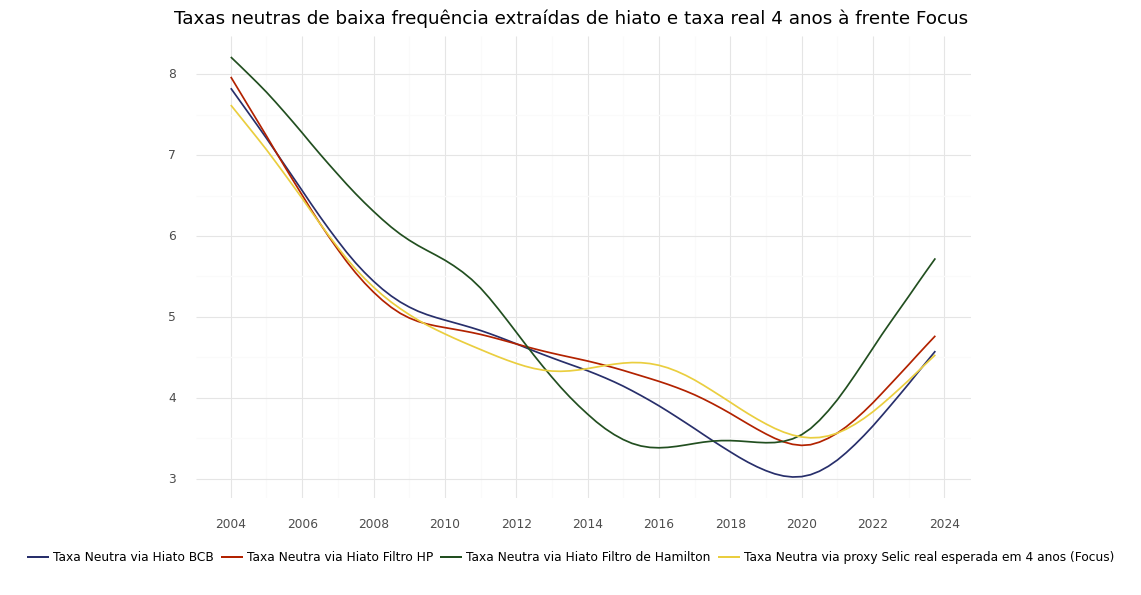

<ggplot: (164276369917)>

In [34]:
# cria o gráfico
(
 ggplot(proxy2_bf, aes(x = 'date_quarter', y = 'values', color = 'proxy')) +
 geom_line(size = 0.7) +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
 labs(title = "Taxas neutras de baixa frequência extraídas de hiato e taxa real 4 anos à frente Focus",
      color="",
      x="",
      y="")+
 theme_minimal() +
 theme(legend_position = "bottom",
       figure_size = (10, 6))
)

# 1.3. Taxas reais de mercado descontando prêmio a termo

Esta estimativa é baseada em taxas reais de mercado em prazos mais longos, para as quais se faz necessário descontar o prêmio a termo. As taxas de juros reais de mercado aqui utilizadas são extraídas das Notas do Tesouro Nacional Série B (NTN-B). As NTN-B são títulos emitidos pelo Tesouro Nacional com atualização do valor nominal pela variação do Índice Nacional de Preços ao Consumidor Amplo (IPCA) e pagamento de cupom de IPCA.


Para prazos longos, o cupom de IPCA representa uma aproximação bastante razoável para as taxas de juros reais desses títulos.


Para extrair a média do prêmio a termo, calculamos a diferença entre as taxas reais de mercado e as taxas reais da pesquisa Focus em um mesmo horizonte.


A estimativa consiste em usar taxas longas de mercado, assim descontadas, como estimativas diretas para a taxa real neutra, ou seja $R_{t}^{n, mercado} = R_{t}^{mercado} -  \text{prêmio a termo}$.


Na ocasião, utilizamos Taxas com vencimentos longos, tal como a NTN-B 35 e NTN-B 45.

## Dados da NTN-B

In [35]:
# Cria função para coletar os dados de títulos do tesouro direto
def tesouro_direto():
  url = 'https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv'
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True)
  df['Data Base']       = pd.to_datetime(df['Data Base'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :1])
  df = df.set_index(multi_indice).iloc[: , 1:]
  df = df.rename(columns = {'Data Vencimento' : 'matur',
                            'Data Base': 'data',
                            'Taxa Compra Manha' : 'taxa_bid'})
  return df

In [36]:
# Importa os dados
titulos = tesouro_direto()

In [37]:
titulos

,matur,data,taxa_bid,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
Tipo Titulo,,,,,,,
Tesouro Prefixado,2006-07-01,2005-01-24,18.54,18.62,784.82,784.06,783.53
Tesouro IPCA+ com Juros Semestrais,2006-08-15,2005-01-24,8.82,8.84,1471.03,1470.64,1469.83
Tesouro IPCA+ com Juros Semestrais,2009-05-15,2005-01-24,8.83,8.87,1365.04,1363.15,1362.40
Tesouro IPCA+ com Juros Semestrais,2045-05-15,2005-01-24,9.03,9.13,1032.62,1021.67,1021.10
Tesouro IPCA+ com Juros Semestrais,2024-08-15,2005-01-24,8.86,8.94,1148.07,1139.54,1138.92
...,...,...,...,...,...,...,...
Tesouro Prefixado,2011-01-01,2010-01-21,10.33,10.37,911.69,911.38,911.02
Tesouro Prefixado,2012-01-01,2010-01-21,11.78,11.83,806.01,805.31,804.95
Tesouro Prefixado,2013-01-01,2010-01-21,12.37,12.43,710.33,709.22,708.89


In [38]:
# Filtra para a NTN-B
ntnb = titulos.loc['Tesouro IPCA+ com Juros Semestrais']

# Cria coluna de ano inteiro para a maturidade
ntnb['matur_year'] = ntnb.matur.dt.year

C:\Users\pedro\AppData\Local\Temp\ipykernel_29360\437906367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [39]:
ntnb

,matur,data,taxa_bid,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha,matur_year
Tipo Titulo,,,,,,,,
Tesouro IPCA+ com Juros Semestrais,2006-08-15,2005-01-24,8.82,8.84,1471.03,1470.64,1469.83,2006
Tesouro IPCA+ com Juros Semestrais,2009-05-15,2005-01-24,8.83,8.87,1365.04,1363.15,1362.40,2009
Tesouro IPCA+ com Juros Semestrais,2045-05-15,2005-01-24,9.03,9.13,1032.62,1021.67,1021.10,2045
Tesouro IPCA+ com Juros Semestrais,2024-08-15,2005-01-24,8.86,8.94,1148.07,1139.54,1138.92,2024
Tesouro IPCA+ com Juros Semestrais,2015-05-15,2005-01-24,8.81,8.89,1237.07,1230.34,1229.66,2015
...,...,...,...,...,...,...,...,...
Tesouro IPCA+ com Juros Semestrais,2013-05-15,2010-01-22,6.64,6.68,1861.40,1859.31,1857.77,2013
Tesouro IPCA+ com Juros Semestrais,2012-08-15,2010-01-22,6.37,6.41,1905.90,1904.22,1902.67,2012
Tesouro IPCA+ com Juros Semestrais,2011-05-15,2010-01-22,5.29,5.31,1910.70,1910.24,1908.76,2011


In [40]:
# Filtra NTN-B 35
ntnb_t35 = ntnb[(
            ntnb
            .matur_year == 2035)
            ]

# Filtra NTN-B 45
ntnb_t45 = ntnb[(
            ntnb
            .matur_year == 2045)
            ]

In [41]:
# Trata os dados e trimestraliza
ntnb_t35 = (
              ntnb_t35
              .reset_index(drop = True)
              .assign(date_quarter = lambda x: pd.PeriodIndex(x['data'], freq = 'Q'))
              .loc[:, ['date_quarter', 'taxa_bid', 'matur_year']]
              .groupby(by = 'date_quarter')
              .agg(taxa_bid_35 = ('taxa_bid', 'mean'))
              .reset_index()
            )

# Trata os dados e trimestraliza
ntnb_t45 = (
              ntnb_t45
              .reset_index(drop = True)
              .assign(date_quarter = lambda x: pd.PeriodIndex(x['data'], freq = 'Q'))
              .loc[:, ['date_quarter', 'taxa_bid', 'matur_year']]
              .groupby(by = 'date_quarter')
              .agg(taxa_bid_45 = ('taxa_bid', 'mean'))
              .reset_index()
            )

In [42]:
ntnb_t45

,date_quarter,taxa_bid_45
0,2004Q4,9.050000
1,2005Q1,9.041803
2,2005Q2,9.081587
3,2005Q3,9.092308
4,2005Q4,9.083226
...,...,...
74,2023Q2,5.819508
75,2023Q3,5.489844
76,2023Q4,5.746667
77,2024Q1,5.682295


In [43]:
# Lista de dfs para juntar
dfs = [proxy_neutro_t4, ntnb_t35, ntnb_t45]

# Junta os dfs
termos = reduce(lambda left, right: pd.merge(right, left, on = 'date_quarter', how = 'left'), dfs).dropna()

termos

,date_quarter,taxa_bid_45,taxa_bid_35,neutro
6,2006Q2,8.511475,8.637037,6.530627
7,2006Q3,8.183594,8.252812,6.703778
8,2006Q4,7.775833,7.897667,5.953297
9,2007Q1,7.309355,7.396452,4.807692
10,2007Q2,6.158871,6.190000,4.453875
...,...,...,...,...
74,2023Q2,5.819508,5.677049,4.833656
75,2023Q3,5.489844,5.294844,4.998616
76,2023Q4,5.746667,5.640333,4.830918
77,2024Q1,5.682295,5.592131,4.791209


In [44]:
# Aplica o cálculo da Taxa real de mercado descontando prêmio a termo
termos['taxa_real_35'] =  (termos.taxa_bid_35 - (termos.taxa_bid_35 - termos.neutro).mean())
termos['taxa_real_45'] =  (termos.taxa_bid_45 - (termos.taxa_bid_45 - termos.neutro).mean())

In [45]:
termos.head()

,date_quarter,taxa_bid_45,taxa_bid_35,neutro,taxa_real_35,taxa_real_45
6,2006Q2,8.511475,8.637037,6.530627,7.330583,7.147637
7,2006Q3,8.183594,8.252812,6.703778,6.946358,6.819756
8,2006Q4,7.775833,7.897667,5.953297,6.591213,6.411995
9,2007Q1,7.309355,7.396452,4.807692,6.089998,5.945517
10,2007Q2,6.158871,6.190000,4.453875,4.883546,4.795033


### Visualiza os dados

In [46]:
# Realiza tratamento para o plot
proxy3 = (
    termos
    .drop(['taxa_bid_45', 'taxa_bid_35', 'neutro'], axis = 1)
    .assign(date_quarter = lambda x: x.date_quarter.dt.to_timestamp())
    .rename(columns = {'taxa_real_35' : 'NTN-B 35',
                       'taxa_real_45' : 'NTN-B 45'})
     .melt(id_vars = ['date_quarter'], var_name = 'proxy', value_name = 'values')
  )
proxy3

,date_quarter,proxy,values
0,2006-04-01,NTN-B 35,7.330583
1,2006-07-01,NTN-B 35,6.946358
2,2006-10-01,NTN-B 35,6.591213
3,2007-01-01,NTN-B 35,6.089998
4,2007-04-01,NTN-B 35,4.883546
...,...,...,...
141,2023-04-01,NTN-B 45,4.455670
142,2023-07-01,NTN-B 45,4.126006
143,2023-10-01,NTN-B 45,4.382828
144,2024-01-01,NTN-B 45,4.318457


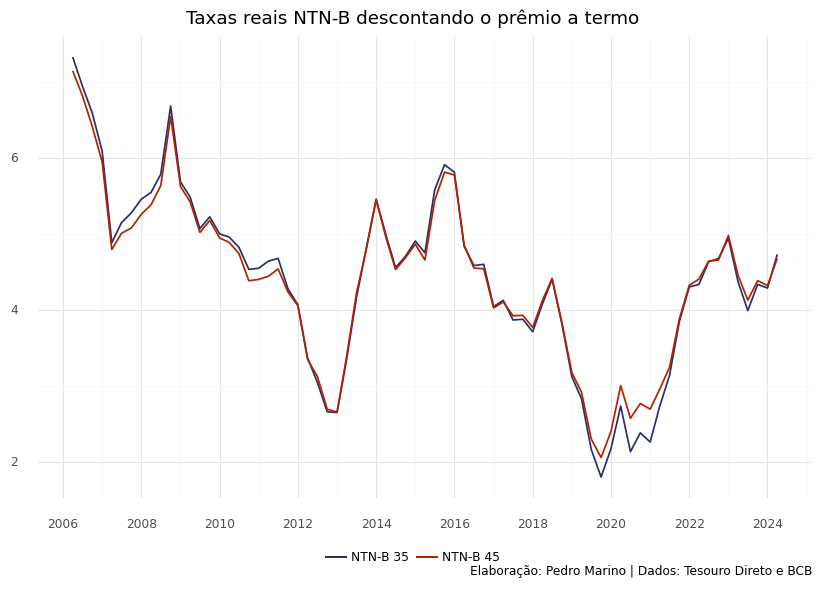

<ggplot: (164276388124)>

In [47]:
(
 ggplot(proxy3, aes(x = 'date_quarter', y = 'values', color = 'proxy')) +
 geom_line(size = 0.7) +
 scale_colour_manual(values = list(colors.values())) +
 scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
 labs(title = "Taxas reais NTN-B descontando o prêmio a termo",
      color="",
      x="",
      y="",
      caption = "Elaboração: Pedro Marino | Dados: Tesouro Direto e BCB")+
 theme_minimal() +
 theme(legend_position = "bottom",
       figure_size = (10, 6))
)

# 1.4 Taxa real de mercado de longo prazo com Filtro HP

Essa estimativa é baseada em Barbosa, Camêlo, e João (2015).

Supondo que a taxa de juros de um título público brasileiro emitido em reais seja igual à taxa de juros internacional oferecida pelos títulos públicos brasileiros emitidos em dólares, podemos considerar essa taxa como uma estimativa razoável da taxa de juros natural. Nesse contexto, é possível analisar o componente de tendência da taxa de um título brasileiro de longo prazo, como a NTN-B, que está vinculada ao Índice de Preços ao Consumidor Ampliado (IPCA) calculado pelo IBGE. Para avaliar essa tendência a longo prazo, procedemos ao cálculo da evolução da taxa desse título com vencimento em 2045.







In [48]:
# Define o índice
ntnb_t45.set_index('date_quarter', inplace = True)

# Calcula o filtro HP
filtro_hp_taxa = sm.tsa.filters.hpfilter(x = ntnb_t45['taxa_bid_45'], lamb = 1600)

# Salva a tendência calculada
proxy4 = pd.DataFrame(filtro_hp_taxa[1]) # posição 1 é a tendência (0=ciclo);

# reinicia o índice e transforma a coluna date_quarter para datetime
proxy4 = proxy4.reset_index().assign(date_quarter = lambda x: x.date_quarter.dt.to_timestamp())

In [49]:
proxy4.tail(10)

,date_quarter,taxa_bid_45_trend
69,2022-01-01,5.099081
70,2022-04-01,5.187662
71,2022-07-01,5.279154
72,2022-10-01,5.372120
73,2023-01-01,5.465574
74,2023-04-01,5.558935
75,2023-07-01,5.652172
76,2023-10-01,5.745417
77,2024-01-01,5.838698
78,2024-04-01,5.932046


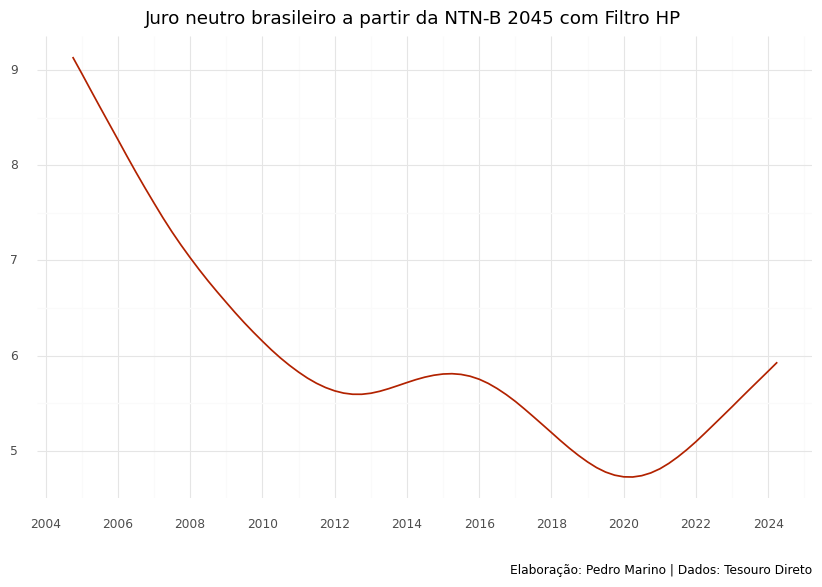

<ggplot: (127930749178)>

In [69]:
# Cria o gráfico
(
 ggplot(proxy4, aes(x = 'date_quarter', y = 'taxa_bid_45_trend')) +
 geom_line(size = 0.7, color = list(colors.values())[1]) +
 scale_x_date(date_breaks = "2 year", date_labels = "%Y") +
 labs(title = "Juro neutro brasileiro a partir da NTN-B 2045 com Filtro HP",
      color="",
      x="",
      y="",
      caption = "Elaboração: Pedro Marino | Dados: Tesouro Direto")+
 theme_minimal() +
 theme(legend_position = "bottom",
       figure_size = (10, 6))
)

### Referências

Banco Central (2023). Boxe: Medidas de taxa de juros real neutra no Brasil. Relatório de Inflação, Junho de 2023. Acesso em: https://www.bcb.gov.br/content/ri/relatorioinflacao/202306/ri202306b6p.pdf

Barbosa, F. H., F. D. Camêlo, and I. C. João. 2015. “A Taxa de Juros Natural e a Regra de Taylor No Brasil: 2003-2015.” Revista Brasileira de Economia 70 (4): 399–417.

BLINDER, A. (1998). “Central banking in theory and practice”, Cambridge: MIT Press.

ROBERTS, J. M. (2018). “An estimate of the long-term neutral rate of interest”, FEDS Notes, Board of Governors of the Federal Reserve System, United States